In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Tuple

import chex
from gymnax import EnvParams, EnvState

import os
import sys
import argparse

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
import gymnax
import optax
import flax
import pickle
import json
from jax.random import split
from functools import partial

import run
import run_bc
import util

from agents.basic import RandomAgent
from algos.ppo_dr import PPO


In [21]:
from mdps.wrappers_mine import ObsNormRand
env, env_params = gymnax.make('CartPole-v1')
env.sample_params = lambda rng: env_params
env = ObsNormRand(env)

In [24]:
from gymnax.environments.spaces import Discrete
for env_id in gymnax.registered_envs:
    env, env_params = gymnax.make(env_id)
    act_space = env.action_space(env_params)
    obs_space = env.observation_space(env_params)
    if isinstance(act_space, Discrete):
        print(env_id)
        print(obs_space.shape, ' -> ', act_space.n)
        print()
        print()




CartPole-v1
(4,)  ->  2


Acrobot-v1
(6,)  ->  3


MountainCar-v0
(2,)  ->  3


Asterix-MinAtar
(10, 10, 4)  ->  5


Breakout-MinAtar
(10, 10, 4)  ->  3


Freeway-MinAtar
(10, 10, 7)  ->  3


SpaceInvaders-MinAtar
(10, 10, 6)  ->  4


Catch-bsuite
(10, 5)  ->  3


DeepSea-bsuite
(8, 8)  ->  2


MemoryChain-bsuite
(3,)  ->  2


UmbrellaChain-bsuite
(3,)  ->  2


DiscountingChain-bsuite
(2,)  ->  5


MNISTBandit-bsuite
(28, 28)  ->  10


SimpleBandit-bsuite
(1, 1)  ->  11


FourRooms-misc
(4,)  ->  4


MetaMaze-misc
(15,)  ->  4


BernoulliBandit-misc
(4,)  ->  2


GaussianBandit-misc
(4,)  ->  2


Pong-misc
(30, 40, 3)  ->  3


In [25]:
import brax

In [38]:
for env_id, v in brax.envs._envs.items():
    env = v()
    print(env_id)
    print(env.observation_size, '->', env.action_size)
    print()
    print()
    

ant
27 -> 8


fast
2 -> 1


halfcheetah
17 -> 6


hopper
11 -> 3


humanoid
244 -> 17


humanoidstandup
244 -> 17


inverted_pendulum
4 -> 1


inverted_double_pendulum
8 -> 1


pusher
23 -> 7


reacher
11 -> 2


swimmer
8 -> 2


walker2d
17 -> 6


In [8]:
from algos.ppo_dr import PPO
from mdps.wrappers_mine import MyGymnaxWrapper
from agents.basic import RandomAgent


In [6]:
class ObsNormRand(MyGymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        n_acts = env.action_space(None).n
        agent = RandomAgent(n_acts)
        ppo = PPO(agent, env, sample_env_params=env.sample_params, n_envs=1024, n_steps=1024)
        
        rng = jax.random.PRNGKey(0)
        carry = ppo.init_agent_env(rng)
        carry, buffer = ppo.eval_step(carry, None)
        obs = buffer['obs']
        self.mean = obs.mean(axis=(0, 1))
        self.std = obs.std(axis=(0, 1))
    
    def reset_env(self, key, params):
        obs, state = self._env.reset_env(key, params)
        obs = (obs - self.mean) / self.std
        return obs, state
    def step_env(self, key, state, action, params):
        obs, state, rew, done, info = self._env.step_env(key, state, action, params)
        obs = (obs - self.mean) / self.std
        return obs, state, rew, done, info

algos.ppo_dr.PPO

In [11]:
rets = run.run(run.parse_args('--n_iters=500 --save_dir=../data/temp/cartpole --save_agent_params=True'.split()))

Config: Namespace(n_seeds=1, env_id='name=CartPole-v1', agent_id='obs_embed=dense;name=linear_transformer;tl=500', run='train', load_dir=None, save_dir='../data/temp/cartpole', save_buffers=False, save_agent_params=True, ft_first_last_layers=False, n_iters=500, n_envs=4, n_steps=128, n_updates=16, n_envs_batch=1, lr=0.00025, clip_grad_norm=0.5, clip_eps=0.2, vf_coef=0.5, ent_coef=0.01, gamma=0.99, gae_lambda=0.95)


  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
rets_student, rets_teacher = run_bc.run(run_bc.parse_args('--n_seeds=32 --n_iters=100 --load_dir_teacher=../data/temp/cartpole --load_dir=../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=linear;mrl=4x64'.split()))

Config: Namespace(n_seeds=32, env_id='name=CartPole-v1', agent_id='obs_embed=dense;name=linear_transformer;tl=500', run='train', load_dir='../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=linear;mrl=4x64', load_dir_teacher='../data/temp/cartpole', save_dir=None, save_buffers=False, save_agent_params=False, ft_first_last_layers=False, n_iters=100, n_envs=4, n_steps=128, n_updates=16, n_envs_batch=1, lr=0.00025, clip_grad_norm=0.5)


  0%|          | 0/100 [00:00<?, ?it/s]

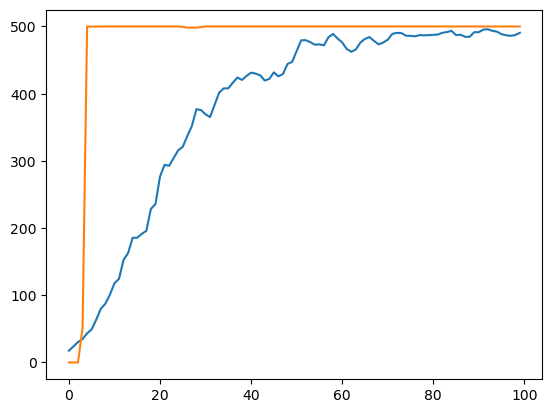

In [13]:
plt.plot(jnp.mean(rets_student, axis=0))
plt.plot(jnp.mean(rets_teacher, axis=0))



In [200]:
env, params = gymnax.make('Freeway-MinAtar')

In [201]:
import jax
from jax.random import split

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)

obs, state = jax.vmap(env.reset, (0, None))(split(rng, 1024), params)
a = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (1024, ), 0, env.action_space(params).n)
    rng, _rng = split(rng)
    obs, state, rew, done, info = jax.vmap(env.step, (0, 0, 0, None))(split(_rng, 1024), state, act, params)
    a.append(rew)

a = jnp.stack(a).flatten()



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.hist(np.asarray(a));
plt.yscale('log')

In [21]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json



In [ ]:
import matplotlib.colors as mcolors
mcolors.TABLEAU_COLORS


(1, 10000)


Text(0.5, 0, 'Training Iteration')

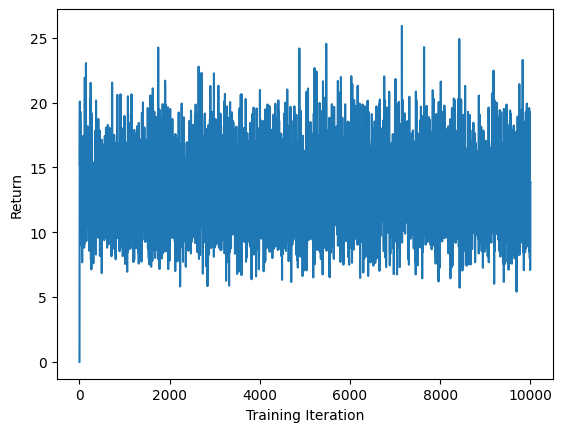

In [67]:
def viz_training(dir_exp):
    with open(f'{dir_exp}/rets.pkl', 'rb') as f:
        rets = pickle.load(f)
        rets = np.asarray(rets)
    print(rets.shape)
    plt.plot(rets.max(axis=0))

# viz_training('../data/exp_01_17/expert/name=CartPole-v1;tl=256')
viz_training('../data/exp_01_17/pretrain/name=csmdp;d_state=2;d_obs=4;n_acts=2;delta=T;trans=linear;rew=goal;mrl=4x64')

plt.ylabel('Return')
plt.xlabel('Training Iteration')



In [62]:
with open('../data/exp_01_17/expert/name=CartPole-v1;tl=256/rets.pkl', 'rb') as f:
    rets = pickle.load(f)
    print(rets[:, -1])

[224.81836   99.950806 160.56744  243.63483 ]


name=CartPole-v1;tl=256
0.57598424 0.001113675
0.5763377 0.0009120357
0.58179355 0.0012070867
0.5767651 0.0010783826
0.58164513 0.0012992888
0.57707125 0.0011696583
0.57985085 0.0011879356
0.69307435 0.00035772478
0.57787275 0.0012043772


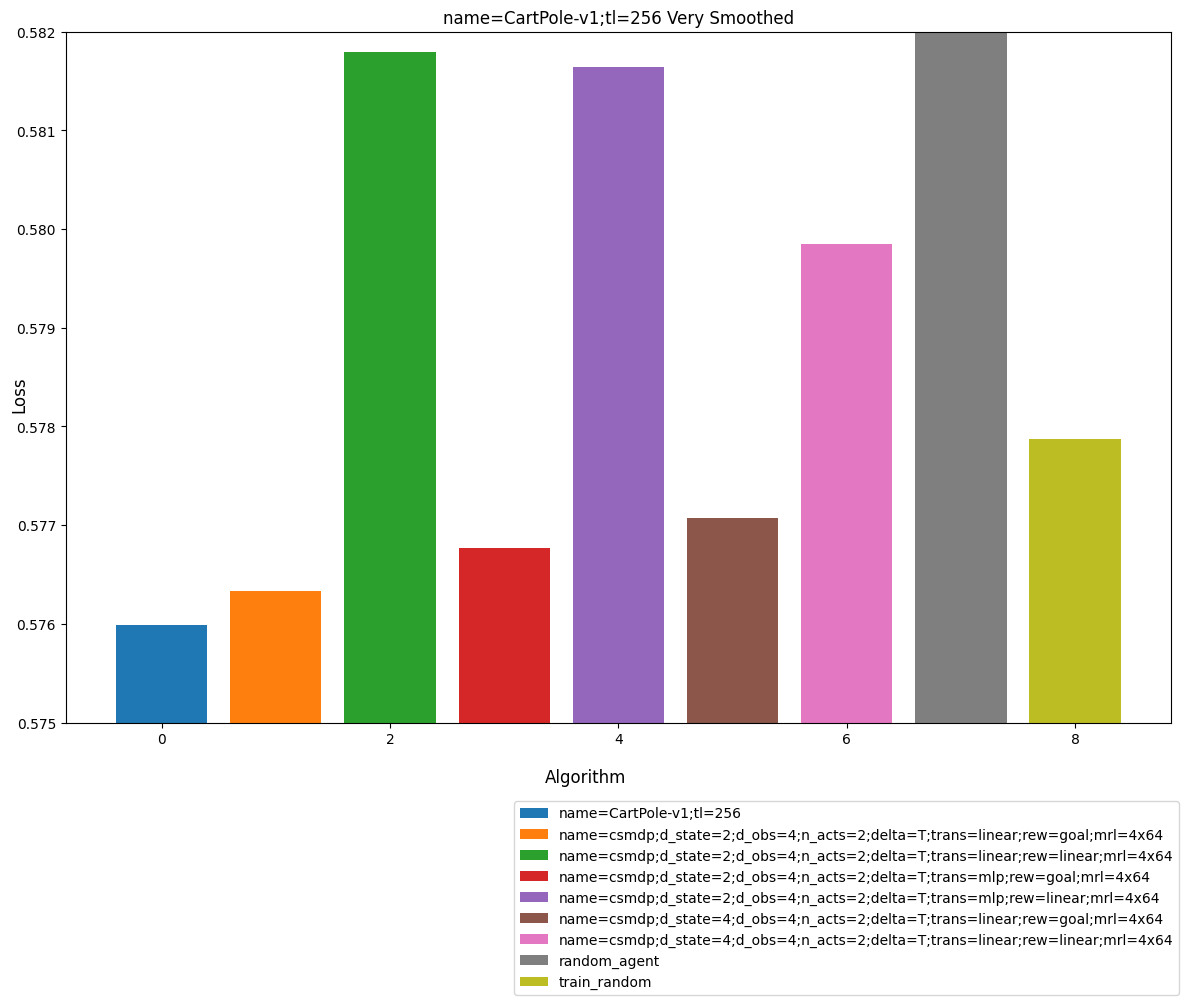

In [16]:
def viz_dir(dir_exp, bar_chart=True):
    plt.figure(figsize=(12, 8))
    i_plt = 0
    for test_dir in sorted(os.listdir(f'{dir_exp}/test/')):
        print(test_dir)
        i_plt += 1
        # plt.subplot(2, 3, i_plt)
        for i, train_dir in enumerate(sorted(os.listdir(f'{dir_exp}/test/{test_dir}/'))):
            # with open(f'{dir_exp}/test/{test_dir}/{train_dir}/rets_student.pkl', 'rb') as f:
            #     rets = pickle.load(f)
            with open(f'{dir_exp}/test/{test_dir}/{train_dir}/losses.pkl', 'rb') as f:
                rets = pickle.load(f)
                rets = rets[:, :, 0].T # s, n

                kernel = np.ones((20,))/20
                conv_fn = partial(jnp.convolve, mode='valid')
                rets = jax.vmap(conv_fn, in_axes=(0, None))(rets, kernel)
                rets = rets.mean(axis=-1)
                rets = rets.mean(axis=0)

                # rets = jnp.convolve(rets, jnp.ones((20,))/20, mode='valid', axis=-1)
                
                # rets = jnp.mean(rets, axis=0) # shape: (T, )
                # now let's convolve it to smooth it out
                # rets = jnp.convolve(rets, jnp.ones((20,))/20, mode='valid', axis=-1)
                
                if bar_chart:
                    plt.bar(i, rets.mean(), label=train_dir)
                else:
                    plt.plot(rets[:], label=train_dir)
        plt.title(test_dir + " Very Smoothed")
    plt.gcf().supxlabel('Algorithm' if bar_chart else 'Training Iteration')
    # plt.gcf().supylabel('End Return' if bar_chart else 'Return')
    plt.gcf().supylabel('Loss' if bar_chart else 'Loss')
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, bbox_to_anchor=(1, 0))
    plt.ylim(0.575, 0.582)

viz_dir('../data/exp_01_17/', bar_chart=True)


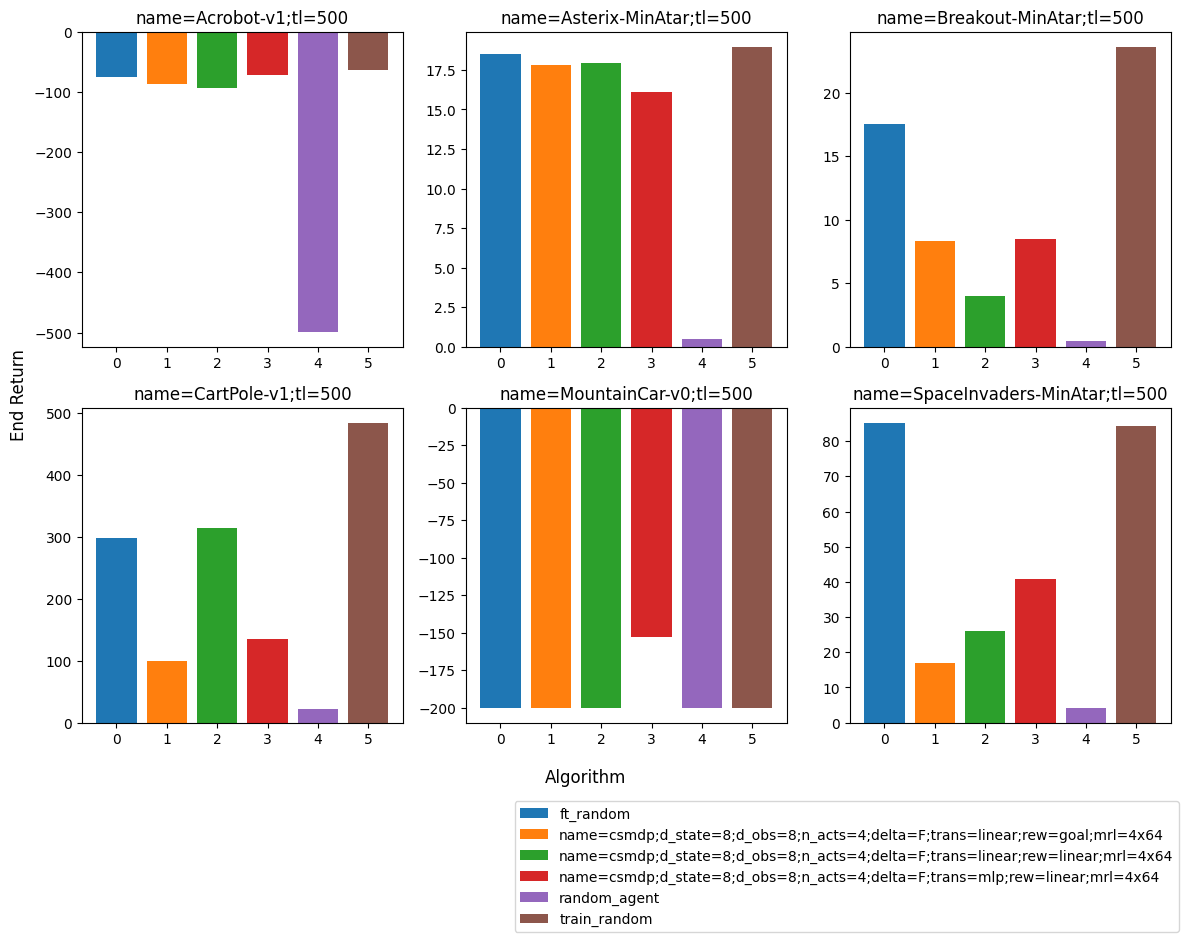

In [35]:
def viz_dir(dir_exp, bar_chart=True):
    # for d in glob.glob(f'{dir_exp}/train/*'):
    #     print(d)
    #     with open(f'{d}/config.json', 'r') as f:
    #         cfg = json.load(f)
    #         print(cfg)
    
    plt.figure(figsize=(12, 8))
    i_plt = 0
    for test_dir in sorted(os.listdir(f'{dir_exp}/test/')):
        i_plt += 1
        plt.subplot(2, 3, i_plt)
        for i, train_dir in enumerate(sorted(os.listdir(f'{dir_exp}/test/{test_dir}/'))):
            with open(f'{dir_exp}/test/{test_dir}/{train_dir}/rets.pkl', 'rb') as f:
                rets = pickle.load(f)
                rets = np.asarray(rets)
                if bar_chart:
                    plt.bar(i, rets[0, -100:].mean(), label=train_dir)
                else:
                    plt.plot(rets[0], label=train_dir)
        plt.title(test_dir)
        
        # print(test_dir)
        # print(rets)
    plt.gcf().supxlabel('Algorithm' if bar_chart else 'Training Iteration')
    plt.gcf().supylabel('End Return' if bar_chart else 'Return')
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, bbox_to_anchor=(1, 0))



viz_dir('../data/exp_main/', bar_chart=True)



Text(0.5, 0, 'In-Context Env Steps')

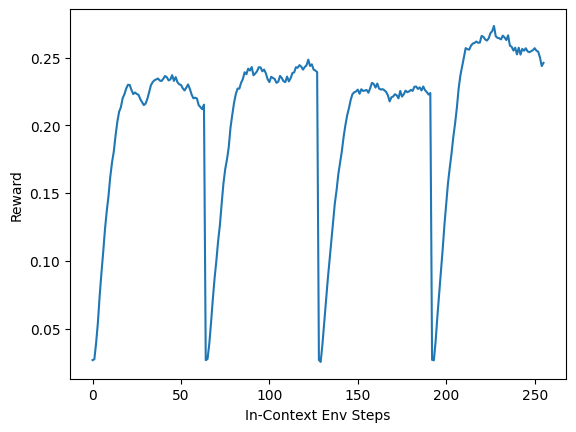

In [75]:
env_id = "name=csmdp;d_state=2;d_obs=8;n_acts=4;delta=T;trans=linear;rew=linear;mrl=4x64"
agent_id = "obs_embed=dense;name=linear_transformer;tl=500"
with open(f'../data/exp_tbc/pretrain/{env_id}/agent_params.pkl', 'rb') as f:
    agent_params = pickle.load(f)
    agent_params = jax.tree_map(lambda x: x[0], agent_params)
    
env = run.create_env(env_id)
n_acts = env.action_space(None).n
agent = run.create_agent(agent_id, env_id, n_acts)

from algos.ppo_dr import PPO
ppo = PPO(agent, env, sample_env_params=env.sample_params, tx=None, n_envs=128, n_steps=256, n_updates=0)

rng = jax.random.PRNGKey(0)
carry = ppo.init_agent_env(rng)
rng, train_state, env_params, agent_state, obs, env_state = carry
train_state = train_state.replace(params=agent_params)
carry = rng, train_state, env_params, agent_state, obs, env_state

carry, buffer = ppo.eval_step(carry, None)

plt.plot(buffer['rew'].mean(axis=1))

plt.ylabel('Reward')
plt.xlabel('In-Context Env Steps')



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from ppo_metagrid import make_train

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 16*4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 16*5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": True,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1 + 32)
    out = train_fn(jnp.arange(len(_rng)), jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    # rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    # import matplotlib.pyplot as plt
    # 
    # n_iters = rets.shape[1]
    # steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    # plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    # plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    # plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    # plt.legend()
    # plt.ylabel('Return')
    # plt.xlabel('Env Steps')
    # plt.show()
    # 
    # plt.plot(jnp.mean(rets[:, :10, :, :], axis=(0, 1, 3)), label='start of training')
    # plt.plot(jnp.mean(rets[:, -10:, :, :], axis=(0, 1, 3)), label='end of training')
    # plt.legend()
    # plt.xlabel('in context steps')
    # plt.show()
    

In [ ]:
rews = metrics  # seed, iter, step, env
rets = rews.sum(axis=2)  # seed, iter, env
rews.shape, rets.shape

In [ ]:
n_iters = rews.shape[1]
iters = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]

plt.plot(iters, jnp.mean(rets.mean(axis=-1), axis=0), label='mean')
plt.plot(iters, jnp.median(rets.mean(axis=-1), axis=0), label='median')
plt.plot(iters, rets.mean(axis=-1).T, c='gray', alpha=0.1)
plt.legend()
plt.ylabel('Return')
plt.xlabel('Env Steps')
plt.title('MetaGridEnv 64x128, Agent: MetaRLLinearTransformer')
plt.show()


In [ ]:
plt.plot(jnp.mean(rews[:, :10].mean(axis=(1, 3)), axis=0), c=[.5, 0, 0, 1], label='mean start of training')
plt.plot(jnp.mean(rews[:, -10:].mean(axis=(1, 3)), axis=0), c=[0, .5, 0, 1], label='mean end of training')

plt.plot(rews[:, :10].mean(axis=(1, 3)).T, c=[.5, 0, 0, .1])
plt.plot(rews[:, -10:].mean(axis=(1, 3)).T, c=[0, .5, 0, .1])

plt.legend()
plt.ylabel('Per-Step Reward')
plt.xlabel('In-Context Steps')
plt.title('MetaGridEnv 64x128, Agent: MetaRLLinearTransformer')
plt.show()


In [133]:
def random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256):
    n_acts = env.action_space(env_params).n
    def step(carry, _):
        rng, state = carry
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (n_envs,), 0, n_acts)
        rng, _rng = split(rng)
        obs, state_n, rew, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(_rng, n_envs), state, act, env_params)
        carry = rng, state_n
        return carry, dict(obs=obs, state=state, act=act, rew=rew, done=done, info=info)
    rng, _rng = split(rng)
    obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(_rng, n_envs), env_params)
    carry = rng, state
    carry, buffer = jax.lax.scan(step, carry, jnp.arange(n_steps))
    buffer = jax.tree_map(lambda x: rearrange(x, 'T N ... -> N T ...'), buffer)
    return buffer


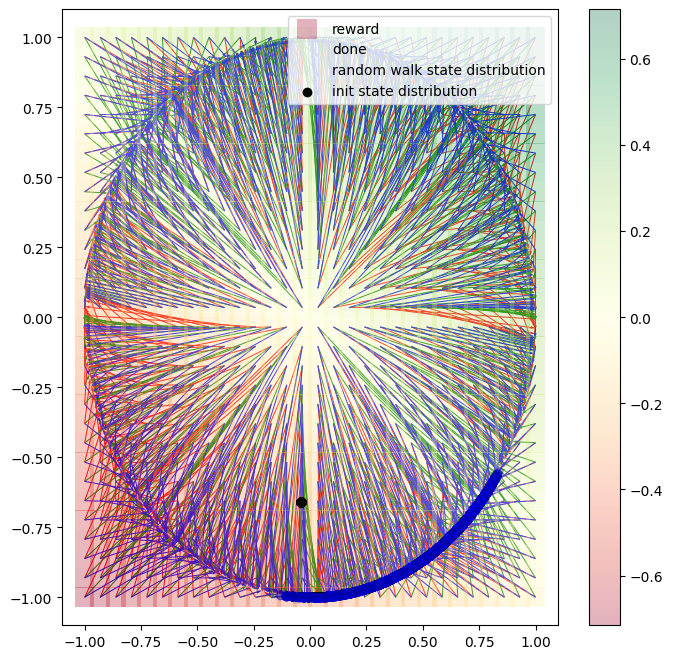

In [141]:

def plot_env(env, env_params):
    state_space = env.state_space(env_params)
    n_acts = env.action_space(env_params).n
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]
    
    lim = jnp.stack([jnp.ones(state_space.shape) * state_space.low, jnp.ones(state_space.shape) * state_space.high])
    xlim, ylim = lim.T

    nlen = 30
    x, y = jnp.linspace(*xlim, nlen), jnp.linspace(*ylim, nlen)
    x, y = jnp.meshgrid(x, y, indexing='ij')
    state_all = rearrange(jnp.stack([x, y], axis=-1), "i j s -> (i j) s")
    act = jnp.arange(n_acts)

    step_fn = partial(env.step, params=env_params)
    step_fn = jax.vmap(jax.vmap(step_fn, in_axes=(None, 0, None)), in_axes=(None, None, 0))
    _rng = jax.random.PRNGKey(0)
    _, state_all_n, _, _, _ = step_fn(_rng, state_all, act)
    
    state, state_n = repeat(state_all, 'ij d -> (a ij) d', a=n_acts), rearrange(state_all_n, 'a ij d -> (a ij) d')
    c = []
    for col in cols:
        c.extend([col] * (nlen * nlen))
    plt.quiver(*state.T, *(state_n-state).T, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
    
    
    rew_all = jax.vmap(env.get_rew, in_axes=(0, None))(state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(0, None))(state_all, env_params)
    plt.scatter(*state_all.T, c=rew_all, cmap='RdYlGn', alpha=0.3, vmin=rew_all.min(), vmax=rew_all.max(), s=200., label='reward', marker='s', edgecolor='none')
    plt.colorbar()

    # done_all = done_all.at[:100].set(True)
    c = jnp.stack([jnp.zeros_like(done_all), jnp.zeros_like(done_all), jnp.zeros_like(done_all), done_all/2.], axis=-1)
    plt.scatter(*state_all.T, c=c, s=200., label='done', marker='x')#, edgecolor='none')

    buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    
    state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    plt.scatter(*state.T, color=(0,0,1,0.01), label='random walk state distribution')
    state = buffer['state'][:, 0]  # N T D=2
    plt.scatter(*state.T, color=(0,0,0,1.), label='init state distribution')
    
    plt.legend()

env_id = "name=csmdp;d_state=2;d_obs=8;n_acts=3;delta=T;trans=linear;rew=linear;mrl=4x64"
    
env = run.create_env(env_id)
env = env._env._env._env
rng = jax.random.PRNGKey(0)
env_params = env.sample_params(rng)
plt.figure(figsize=(8, 8))
plot_env(env, env_params)

In [169]:
nlen = 20
xlim, ylim = (-1, 1), (-1, 1)
x, y = jnp.linspace(*xlim, nlen), jnp.linspace(*ylim, nlen)
x, y = jnp.meshgrid(x, y, indexing='ij')
state_all = jnp.stack([x, y], axis=-1)
reachable = jnp.zeros((nlen, nlen))
_, state_init = env.reset(jax.random.PRNGKey(0), env_params)
bin_init = ((state_init+1)/2.*nlen).astype(int)
reachable = reachable.at[bin_init[0], bin_init[1]].set(1)

In [170]:
for i in range(10):
    rng = jax.random.PRNGKey(i)
    rng, _rng = split(rng)
    state = jax.random.uniform(rng, (1000, 2), minval=-1, maxval=1.)
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (1000, ), minval=0, maxval=4)
    rng, _rng = split(rng)
    obs, state_n, _, _, _ = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(rng, 1000), state, act, env_params)
    bin = ((state+1)/2.*nlen).astype(int)
    bin_n = ((state_n+1)/2.*nlen).astype(int)
    reachable = reachable.at[bin_n[:, 0], bin_n[:, 1]].set(jnp.maximum(reachable[bin_n[:, 0], bin_n[:, 1]], reachable[bin[:, 0], bin[:, 1]]))



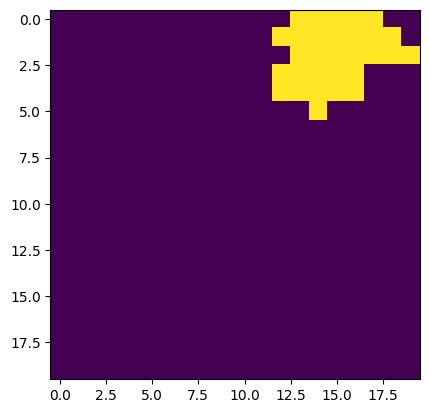

In [171]:
plt.imshow(reachable, vmin=0, vmax=1)

In [35]:
env.reset(rng, env_params)

(Array([-2.0289757 , -1.7129874 ,  1.8201582 , -0.9108537 , -2.129796  ,
        -3.021924  ,  0.48640096,  0.03991027], dtype=float32),
 Array([-0.0398829 , -0.65906525], dtype=float32))

In [76]:
data = {}
for d in os.listdir("../data/exp_trans_type/test/name=CartPole-v1;tl=500/"):
    with open(f"../data/exp_trans_type/test/name=CartPole-v1;tl=500/{d}/losses.pkl", 'rb') as f:
        data[d] = pickle.load(f).mean(axis=-1).mean(axis=-1)
        

In [77]:
a = np.zeros((4,4, 300))
for i, iname in enumerate(['first', 'last', 'first_last', 'all']):
    for j, jname in enumerate(['first', 'last', 'first_last', 'all']):
        a[i, j] = data[f'{iname}_{jname}']
        
    

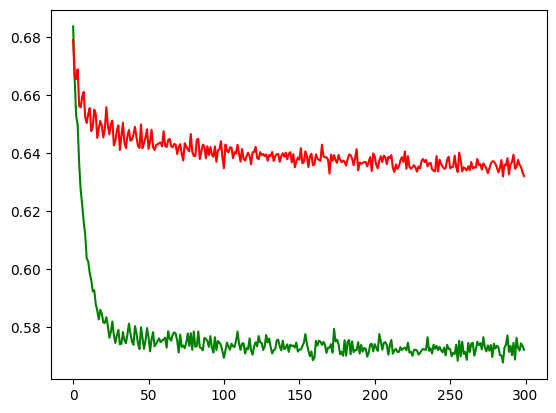

In [175]:
plt.plot(a[1, 1], c='g')
plt.plot(a[3, 1], c='r')
plt.show()


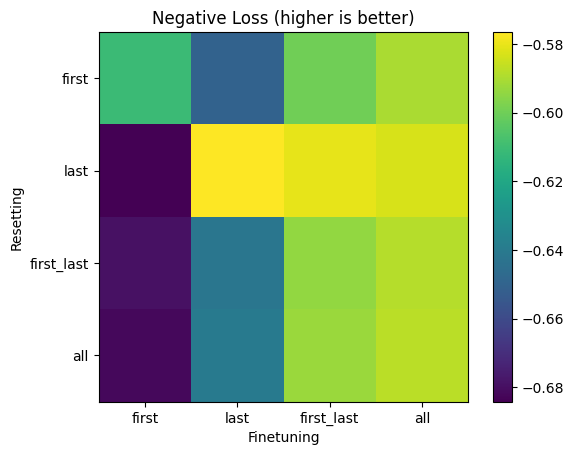

In [78]:
plt.imshow(-a.mean(axis=-1))
plt.xticks(range(4), ['first', 'last', 'first_last', 'all'])
plt.yticks(range(4), ['first', 'last', 'first_last', 'all'])
plt.colorbar()
plt.ylabel('Resetting')
plt.xlabel('Finetuning')
plt.title("Negative Loss (higher is better)")
plt.show()

In [14]:
def single_episode(rng, gridlen=32, n_trials=4, n_steps=32):
    act_map = jnp.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    rng, _rng = split(rng)
    state_goal = jax.random.randint(_rng, (2,), 0, gridlen)
    rng, _rng = split(rng)
    obs_matrix = jax.random.normal(_rng, (8, 2))
    
    def single_trial(rng):
        def step(carry, _):
            rng, state, = carry
        
            delta = (state_goal-state).clip(-1, 1)
            logits = 1.5 * jnp.array([delta[0]>0, delta[1]>0, delta[0]<0, delta[1]<0]) * 100
            rng, _rng = split(rng)
            act = jax.random.categorical(_rng, logits)
            
            obs = obs_matrix @ (state/gridlen*2.-1.)
            
            state_n = state + act_map[act]
            carry = rng, state_n,
            return carry, dict(obs=obs, state=state, logits=logits, act=act)

        rng, _rng = split(rng)
        state_start = jax.random.randint(_rng, (2,), 0, gridlen)
        carry = rng, state_start,
        carry, buffer = jax.lax.scan(step, carry, jnp.arange(n_steps))
        return buffer
    return jax.vmap(single_trial)(split(rng, n_trials))
rng = jax.random.PRNGKey(1)
buffer = single_episode(rng)

print(jax.tree_map(lambda x: x.shape, buffer))


{'act': (4, 32), 'logits': (4, 32, 4), 'obs': (4, 32, 8), 'state': (4, 32, 2)}


In [28]:
def kl_div(logits, logits_target, axis=-1):
    log_p, log_q = jax.nn.log_softmax(logits_target), jax.nn.log_softmax(logits)
    return (jnp.exp(log_p) * (log_p - log_q)).sum(axis=axis)


In [29]:
n_envs, n_steps = 32, 128
rng = jax.random.PRNGKey(0)
agent = run.create_agent("obs_embed=dense;name=linear_transformer;tl=500", "name=fejiwao", n_acts=4)
init_with_out_init_state = partial(agent.init_with_output, method=agent.init_state)
rng, _rng = split(rng)
agent_state, _ = jax.vmap(init_with_out_init_state, in_axes=(None, 0))(rng, split(_rng, n_envs))

agent_state0 = jax.tree_map(lambda x: x[0], agent_state)
obs0 = dict(obs=jnp.zeros((8, )), act_p=jnp.zeros((), dtype=int), rew_p=jnp.zeros(()), done=jnp.zeros((), dtype=bool))
rng, _rng = split(rng)
agent_params = agent.init(_rng, agent_state0, obs0, method=agent.forward_recurrent)

for i in range(1):
    rng = jax.random.PRNGKey(i)
    buffer = jax.vmap(single_episode)(split(rng, n_envs))
    buffer = jax.tree_map(lambda x: rearrange(x, 'B K T ... -> B (K T) ...'), buffer)

    agent_state, _ = jax.vmap(init_with_out_init_state, in_axes=(None, 0))(rng, split(_rng, n_envs))
    
    obs = dict(obs=buffer['obs'], act_p=jnp.zeros((n_envs, n_steps), dtype=int), rew_p=jnp.zeros((n_envs, n_steps)), done=jnp.zeros((n_envs, n_steps), dtype=bool))
    forward_parallel = partial(agent.apply, method=agent.forward_parallel)
    _, (logits, val) = jax.vmap(forward_parallel, in_axes=(None, 0, 0))(agent_params, agent_state, obs)
    loss = kl_div(logits, buffer['logits'], axis=-1).mean()



(1,)
(128,)
(32, 128, 4)
(32, 128, 4)
(32, 128)


In [33]:
def loss_fn(agent_params, rng):
    buffer = jax.vmap(single_episode)(split(rng, n_envs))
    buffer = jax.tree_map(lambda x: rearrange(x, 'B K T ... -> B (K T) ...'), buffer)

    agent_state, _ = jax.vmap(init_with_out_init_state, in_axes=(None, 0))(rng, split(_rng, n_envs))

    obs = dict(obs=buffer['obs'], act_p=jnp.zeros((n_envs, n_steps), dtype=int), rew_p=jnp.zeros((n_envs, n_steps)), done=jnp.zeros((n_envs, n_steps), dtype=bool))
    forward_parallel = partial(agent.apply, method=agent.forward_parallel)
    _, (logits, val) = jax.vmap(forward_parallel, in_axes=(None, 0, 0))(agent_params, agent_state, obs)
    loss = kl_div(logits, buffer['logits'], axis=-1).mean()
    return loss

for i in tqdm(range(10)):
    rng = jax.random.PRNGKey(i)
    val, grads = jax.value_and_grad(loss_fn)(agent_params, rng=rng)


  0%|          | 0/10 [00:00<?, ?it/s]

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)


In [120]:
from mdps.wrappers_mine import MyGymnaxWrapper
class CartPoleNorm(MyGymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.mean = jnp.array([-0.0001372 ,  0.00055863, -0.00037162, -0.00228286])
        self.std = jnp.array([0.09439703, 0.5317589 , 0.09157456, 0.78328806])
    
    def step_env(self, key, state, action, params):
        obs, state, rew, done, info = self._env.step_env(key, state, action, params)
        obs = (obs - self.mean) / self.std
        return obs, state, rew, done, info

    def reset_env(self, key, params):
        obs, state = self._env.reset_env(key, params)
        obs = (obs - self.mean) / self.std
        return obs, state

    

In [121]:
def random(env, rng, n_envs=1024, n_steps=8192):
    rng, _rng = split(rng)
    obs, state = jax.vmap(env.reset)(split(_rng, n_envs))
    s = []
    for t in tqdm(range(n_steps)):
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (n_envs,), 0, 2)
        rng, _rng = split(rng)
        obs, state, rew, done, info = jax.vmap(env.step)(split(_rng, n_envs), state, act)
        s.append(obs)
    
env, params = gymnax.make('CartPole-v1')
env = CartPoleNorm(env)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [122]:
s = util.tree_stack(s)

In [123]:
s.shape

(5000, 1024, 4)

In [124]:
s.mean(axis=(0, 1)), s.std(axis=(0, 1))

(Array([ 2.8610228e-10,  3.0040741e-09, -1.9645691e-08,  1.3351440e-09],      dtype=float32),
 Array([0.9999999, 1.       , 1.       , 0.9999999], dtype=float32))

In [107]:
(s*jnp.array([6.0383253, 1.0719143, 6.2244363, 0.7277016])).std(axis=(0, 1))

Array([0.56999993, 0.57      , 0.57      , 0.56999993], dtype=float32)

In [92]:
jax.random.uniform(rng, (100000, ), minval=-1, maxval=1).std()

Array(0.5768865, dtype=float32)

In [106]:
.57/jnp.array([0.09439703, 0.5317589 , 0.09157456, 0.78328806])

Array([6.0383253, 1.0719143, 6.2244363, 0.7277016], dtype=float32)

In [ ]:
(Array([-0.0001372 ,  0.00055863, -0.00037162, -0.00228286], dtype=float32),
 Array([0.09439703, 0.5317589 , 0.09157456, 0.78328806], dtype=float32))

In [108]:
# agent = run.create_agent("")

In [ ]:
from mdps.wrappers_mine import MyGymnaxWrapper
class CartPoleNorm(MyGymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.mean = jnp.array([-0.0001372 ,  0.00055863, -0.00037162, -0.00228286])
        self.std = jnp.array([0.09439703, 0.5317589 , 0.09157456, 0.78328806])
    
    def step_env(self, key, state, action, params):
        obs, state, rew, done, info = self._env.step_env(key, state, action, params)
        obs = (obs - self.mean) / self.std
        return obs, state, rew, done, info

    def reset_env(self, key, params):
        obs, state = self._env.reset_env(key, params)
        obs = (obs - self.mean) / self.std
        return obs, state

    

In [128]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
a = jax.random.normal(_rng, (10000, 4, 2))
rng, _rng = split(rng)
b = jax.random.uniform(_rng, (10000, 2, 1), minval=-1, maxval=1)
c = (a@b)[:, :, 0]



ValueError: not enough values to unpack (expected 2, got 1)